In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (confusion_matrix, f1_score, recall_score, precision_score, 
                            accuracy_score, roc_curve, auc, roc_auc_score, 
                            log_loss, brier_score_loss, classification_report)
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb
import lightgbm as lgb
import shap



In [172]:
df = pd.read_csv('shots_2007-2023.csv')
print(f"Dataset Shape: {df.shape}")
print(df.head())

print(f"\nTarget variable 'goal' distribution:\n{df['goal'].value_counts()}")
print(f"Goal rate: {df['goal'].mean():.4f}")


Dataset Shape: (1840218, 124)
   shotID homeTeamCode awayTeamCode  season  isPlayoffGame  game_id  \
0       0          TBL          NSH    2023              0    20001   
1       1          TBL          NSH    2023              0    20001   
2       2          TBL          NSH    2023              0    20001   
3       3          TBL          NSH    2023              0    20001   
4       4          TBL          NSH    2023              0    20001   

   homeTeamWon  id  time  timeUntilNextEvent  ...    xFroze  xRebound  \
0            1  10    61                 9.0  ...  0.249174  0.035816   
1            1  11    70                26.0  ...  0.107945  0.051284   
2            1  13   107                 2.0  ...  0.236193  0.030269   
3            1  19   177                35.0  ...  0.198635  0.033686   
4            1  21   231                29.0  ...  0.188582  0.027146   

  xPlayContinuedInZone xPlayContinuedOutsideZone xPlayStopped  xShotWasOnGoal  \
0             0.379310 

             shotID        season  isPlayoffGame       game_id   homeTeamWon  \
count  1.840218e+06  1.840218e+06   1.840218e+06  1.840218e+06  1.840218e+06   
mean   9.201085e+05  2.015146e+03   7.252782e-02  2.130252e+04  5.417787e-01   
std    5.312253e+05  4.960793e+00   2.593599e-01  2.513023e+03  4.982516e-01   
min    0.000000e+00  2.007000e+03   0.000000e+00  2.000100e+04  0.000000e+00   
25%    4.600542e+05  2.011000e+03   0.000000e+00  2.032200e+04  0.000000e+00   
50%    9.201085e+05  2.015000e+03   0.000000e+00  2.064400e+04  1.000000e+00   
75%    1.380163e+06  2.019000e+03   0.000000e+00  2.098600e+04  1.000000e+00   
max    1.840217e+06  2.023000e+03   1.000000e+00  3.041700e+04  1.000000e+00   

                 id          time  timeUntilNextEvent  timeSinceLastEvent  \
count  1.840218e+06  1.840218e+06        1.840218e+06        1.840218e+06   
mean   1.607135e+02  1.835555e+03        1.145011e+01        1.570407e+01   
std    9.231472e+01  1.058338e+03        1.49593

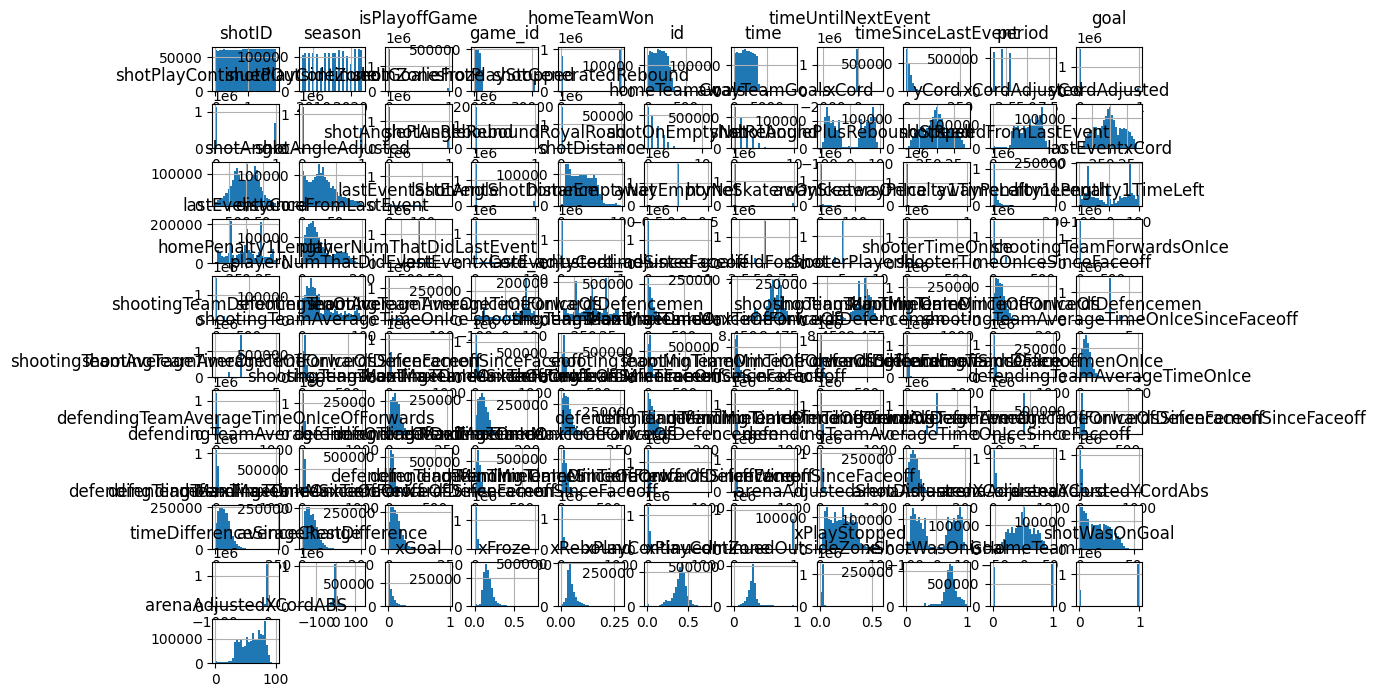

In [173]:
print(df.describe())
print(f"\nData Types:\n{df.dtypes}")

missing_data = df.isnull().sum()
print(f"\nMissing values: {missing_data.sum()}")
if missing_data.sum() > 0:
    df = df.dropna()

print(f"Duplicates: {df.duplicated().sum()}")
if df.duplicated().sum() > 0:
    df = df.drop_duplicates()

numeric_cols = df.select_dtypes(include="number").columns
df[numeric_cols].hist(figsize=(12, 8), bins=30)
plt.tight_layout()
plt.show()

In [174]:
xg_features = [col for col in df.columns if col.startswith('x') and col != 'xCord' and col != 'xCordAdjusted']
df = df.drop(columns=xg_features)

# Exclude outcome-related features that leak information about the shot result
# 'event' encodes the outcome (GOAL, MISS, SHOT) - this is the target!
# 'goal' is the target variable itself - DO NOT drop it!
leakage_features = ['shotWasOnGoal', 'homeTeamWon', 'event']
leakage_features = [col for col in leakage_features if col in df.columns]
if leakage_features:
    df = df.drop(columns=leakage_features)
    print(f"Excluded outcome/leakage features: {leakage_features}")

# Check if lastEventCategory contains goal-related info and exclude if so
if 'lastEventCategory' in df.columns:
    if df['lastEventCategory'].dtype == 'object':
        unique_events = df['lastEventCategory'].unique()
        if 'GOAL' in str(unique_events):
            df = df.drop(columns=['lastEventCategory'])
            print(f"Excluded 'lastEventCategory' (contains GOAL information)")

# Check if 'goal' column exists before accessing it
if 'goal' not in df.columns:
    print(f"Error: 'goal' column not found in dataframe!")
    print(f"Available columns: {df.columns.tolist()}")
    # Try to find potential target columns
    potential_targets = [col for col in df.columns if 'goal' in col.lower() or 'target' in col.lower()]
    if potential_targets:
        print(f"Potential target columns found: {potential_targets}")
    raise KeyError("'goal' column is missing. Please check if it was accidentally dropped or renamed.")
else:
    print(f"Target distribution:\n{df['goal'].value_counts()}")
    print(f"Goal rate: {df['goal'].mean():.4f}")

print(f"\nExcluded {len(xg_features)} xG-related features to prevent data leakage")

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

Excluded outcome/leakage features: ['shotWasOnGoal', 'homeTeamWon', 'event']
Excluded 'lastEventCategory' (contains GOAL information)
Target distribution:
goal
0    1706023
1     116885
Name: count, dtype: int64
Goal rate: 0.0641

Excluded 7 xG-related features to prevent data leakage


In [175]:
# Only encode categorical features that don't leak outcome information
# Exclude 'lastEventCategory' if it contains GOAL (already handled above)
categorical_cols_to_encode = ['shotType', 'shooterLeftRight']
# Only add lastEventCategory if it wasn't excluded
if 'lastEventCategory' in df.columns:
    categorical_cols_to_encode.append('lastEventCategory')

ohe_cols = [col for col in categorical_cols_to_encode if col in df.columns]
if ohe_cols:
    df = pd.get_dummies(df, columns=ohe_cols, drop_first=False)
    print(f"One-hot encoded columns: {ohe_cols}")
    
    # Ensure encoded columns are numeric (they should be, but verify)
    encoded_cols = [col for col in df.columns if any(col.startswith(prefix) for prefix in ohe_cols)]
    for col in encoded_cols:
        if df[col].dtype == 'object':
            df[col] = df[col].astype(int)

drop_cols = ['shotID', 'homeTeamCode', 'awayTeamCode', 'game_id', 'id', 'teamCode', 
             'shooterName', 'goalieNameForShot', 'playerPositionThatDidEvent']
drop_cols = [col for col in drop_cols if col in df.columns]
if drop_cols:
    df = df.drop(columns=drop_cols)
    print(f"Dropped columns: {drop_cols}")

One-hot encoded columns: ['shotType', 'shooterLeftRight']
Dropped columns: ['shotID', 'homeTeamCode', 'awayTeamCode', 'game_id', 'id', 'teamCode', 'shooterName', 'goalieNameForShot', 'playerPositionThatDidEvent']


In [176]:
# Drop columns that might leak information or are not useful for prediction
# 'timeUntilNextEvent' may leak information about what happened after the shot

# CRITICAL: These features describe what happened AFTER the shot - they leak the outcome!
# When a goal is scored, play stops, so these are all 0 for goals
# This creates perfect separability and 100% accuracy
temporal_leakage_features = [
    'shotPlayStopped',           # Play stopped after shot (includes goals!)
    'shotGeneratedRebound',      # Rebound generated (can't happen if goal)
    'shotPlayContinuedInZone',   # Play continued in zone (can't happen if goal)
    'shotPlayContinuedOutsideZone' # Play continued outside zone (can't happen if goal)
]

drop_cols_before_split = ['game_id', 'time', 'id', 'timeUntilNextEvent'] + temporal_leakage_features
drop_cols_before_split = [col for col in drop_cols_before_split if col in df.columns]
if drop_cols_before_split:
    df = df.drop(columns=drop_cols_before_split)
    print(f"Dropped columns before split: {drop_cols_before_split}")
    if any(col in temporal_leakage_features for col in drop_cols_before_split):
        print(f"⚠️  CRITICAL: Dropped temporal leakage features that describe post-shot outcomes!")

y = df['goal']
X = df.drop(columns=['goal'])

print(f"Feature Matrix Shape: {X.shape}")
print(f"Target Classes: {y.unique()}")

Dropped columns before split: ['time', 'timeUntilNextEvent', 'shotPlayStopped', 'shotGeneratedRebound', 'shotPlayContinuedInZone', 'shotPlayContinuedOutsideZone']
⚠️  CRITICAL: Dropped temporal leakage features that describe post-shot outcomes!
Feature Matrix Shape: (1822908, 104)
Target Classes: [0 1]


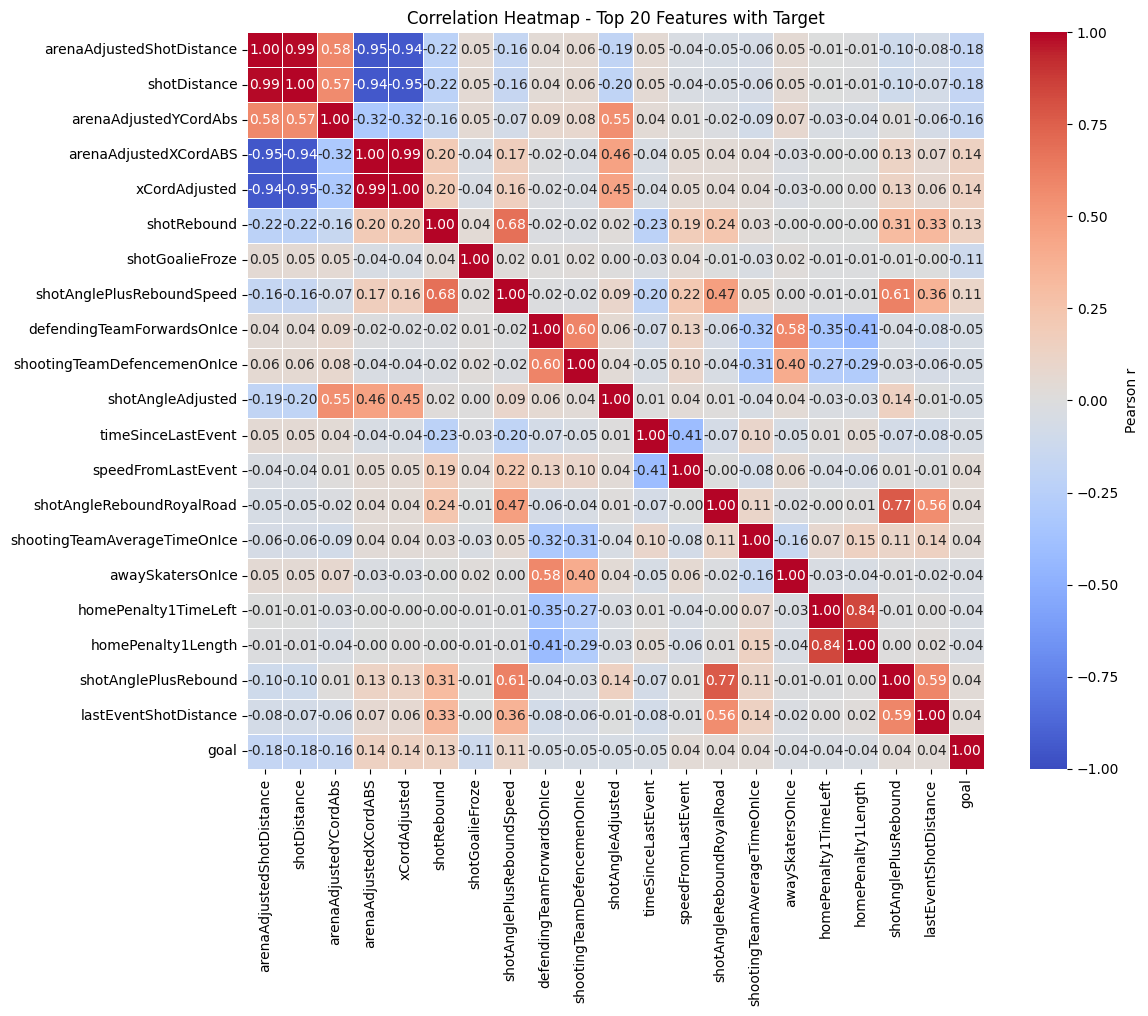

Top features correlated with target:
arenaAdjustedShotDistance      0.177592
shotDistance                   0.175850
arenaAdjustedYCordAbs          0.156926
arenaAdjustedXCordABS          0.143665
xCordAdjusted                  0.143104
shotRebound                    0.132975
shotGoalieFroze                0.113674
shotAnglePlusReboundSpeed      0.105944
defendingTeamForwardsOnIce     0.048950
shootingTeamDefencemenOnIce    0.047755
Name: goal, dtype: float64


In [177]:
temp_df = pd.concat([X, y], axis=1)
numeric_df = temp_df.select_dtypes(include="number")
correlation_matrix = numeric_df.corr(numeric_only=True)

corr_with_target = correlation_matrix['goal'].drop(labels=['goal']).abs().sort_values(ascending=False)
top_features = corr_with_target.head(20).index.tolist()
top_features.append('goal')

top_corr_matrix = correlation_matrix.loc[top_features, top_features]

plt.figure(figsize=(12, 10))
sns.heatmap(top_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", 
            vmin=-1, vmax=1, center=0, square=True, cbar_kws={"label": "Pearson r"},
            linewidths=0.5, linecolor='white')
plt.title("Correlation Heatmap - Top 20 Features with Target")
plt.tight_layout()
plt.show()

print("Top features correlated with target:")
print(corr_with_target.head(10))

In [178]:
# Stratification ensures the proportion of classes (goals vs no-goals) is maintained
# across train/val/test splits. For example, if 10% of shots are goals, then each
# split will have approximately 10% goals. This prevents one split from having
# all goals and another having none, which would bias model evaluation.
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp
)

print(f"Training: {X_train.shape[0]}, Validation: {X_val.shape[0]}, Test: {X_test.shape[0]}")
print(f"\nGoal rate verification (should be similar across splits):")
print(f"Train: {y_train.mean():.4f}, Val: {y_val.mean():.4f}, Test: {y_test.mean():.4f}")
print(f"Overall: {y.mean():.4f}")

Training: 1276035, Validation: 364582, Test: 182291

Goal rate verification (should be similar across splits):
Train: 0.0641, Val: 0.0641, Test: 0.0641
Overall: 0.0641


In [179]:
# CRITICAL: Drop leaky features BEFORE encoding
# 'lastEventTeam' contains "GOAL" as a value - this directly leaks target information!
# 'homeTeamGoals' and 'awayTeamGoals' might be scores AFTER the goal (leakage) - drop to be safe
# These features must be dropped from ALL splits (numeric or categorical)
leaky_features_to_drop = ['lastEventTeam', 'event', 'homeTeamGoals', 'awayTeamGoals']
leaky_features_to_drop = [col for col in leaky_features_to_drop if col in X_train.columns]

if leaky_features_to_drop:
    print(f"⚠️  CRITICAL: Dropping leaky features: {leaky_features_to_drop}")
    X_train = X_train.drop(columns=leaky_features_to_drop)
    X_val = X_val.drop(columns=leaky_features_to_drop)
    X_test = X_test.drop(columns=leaky_features_to_drop)
    print(f"   Features dropped from all splits to prevent data leakage")

# Identify remaining non-numeric columns that need encoding
# Exclude any columns that might encode outcome information
remaining_categorical = X_train.select_dtypes(include=['object']).columns.tolist()

# Remove any columns that might leak outcome information
# 'event' should already be excluded, but double-check
outcome_related = ['event', 'lastEventTeam']
remaining_categorical = [col for col in remaining_categorical if col not in outcome_related]

# Also check if any categorical columns contain goal-related information
if remaining_categorical:
    for col in remaining_categorical.copy():
        if X_train[col].dtype == 'object':
            unique_vals = str(X_train[col].unique()).upper()
            if 'GOAL' in unique_vals:
                print(f"WARNING: Excluding '{col}' - contains GOAL information (data leakage)")
                remaining_categorical.remove(col)

if remaining_categorical:
    print(f"Remaining categorical columns to encode: {remaining_categorical}")

# Store original numeric columns before encoding
train_numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
val_numeric_cols = X_val.select_dtypes(include=[np.number]).columns.tolist()
test_numeric_cols = X_test.select_dtypes(include=[np.number]).columns.tolist()

if remaining_categorical:
    print(f"Encoding remaining categorical columns: {remaining_categorical}")
    
    # Ensure categorical columns are actually object type before encoding
    remaining_categorical = [col for col in remaining_categorical 
                             if col in X_train.columns and X_train[col].dtype == 'object']
    
    if remaining_categorical:
        # Encode training set first to get all possible categories
        X_train_encoded = pd.get_dummies(X_train, columns=remaining_categorical, drop_first=False, dtype=float)
        
        # Get all columns from training set (this defines our feature space)
        all_columns = X_train_encoded.columns.tolist()
        print(f"Training set has {len(all_columns)} features after encoding")
        
        # Encode validation and test sets separately
        X_val_encoded = pd.get_dummies(X_val, columns=remaining_categorical, drop_first=False, dtype=float)
        X_test_encoded = pd.get_dummies(X_test, columns=remaining_categorical, drop_first=False, dtype=float)
    else:
        # No categorical columns to encode
        X_train_encoded = X_train.copy()
        X_val_encoded = X_val.copy()
        X_test_encoded = X_test.copy()
        all_columns = X_train.columns.tolist()
    
    # Create new DataFrames with exact same columns as training (initialized with zeros)
    X_val = pd.DataFrame(0, index=X_val.index, columns=all_columns, dtype=np.float64)
    X_test = pd.DataFrame(0, index=X_test.index, columns=all_columns, dtype=np.float64)
    
    # Copy over numeric columns (these should be the same across all splits)
    for col in train_numeric_cols:
        if col in all_columns:
            if col in X_val_encoded.columns:
                X_val[col] = pd.to_numeric(X_val_encoded[col], errors='coerce').fillna(0).astype(np.float64)
            if col in X_test_encoded.columns:
                X_test[col] = pd.to_numeric(X_test_encoded[col], errors='coerce').fillna(0).astype(np.float64)
    
    # Copy over one-hot encoded columns that exist in both training and val/test
    for col in all_columns:
        if col not in train_numeric_cols:  # This is a one-hot encoded column
            # For validation set
            if col in X_val_encoded.columns:
                # Convert to numeric, handling any string values
                X_val[col] = pd.to_numeric(X_val_encoded[col], errors='coerce').fillna(0).astype(np.float64)
            else:
                X_val[col] = 0.0
            
            # For test set
            if col in X_test_encoded.columns:
                # Convert to numeric, handling any string values
                X_test[col] = pd.to_numeric(X_test_encoded[col], errors='coerce').fillna(0).astype(np.float64)
            else:
                X_test[col] = 0.0
    
    # Use training encoded dataframe and ensure all columns are numeric
    X_train = X_train_encoded[all_columns].copy()
    
    # Convert one-hot encoded columns to numeric if needed
    for col in X_train.columns:
        if col not in train_numeric_cols:
            X_train[col] = pd.to_numeric(X_train[col], errors='coerce').fillna(0).astype(np.float64)
    
    print(f"Final feature count: {X_train.shape[1]}")
    print(f"Validation columns match: {list(X_val.columns) == list(X_train.columns)}")
    print(f"Test columns match: {list(X_test.columns) == list(X_train.columns)}")
else:
    # No categorical columns, just ensure numeric
    X_train = X_train.select_dtypes(include=[np.number])
    X_val = X_val.select_dtypes(include=[np.number])
    X_test = X_test.select_dtypes(include=[np.number])

# Final check: ensure all columns are numeric
non_numeric = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric:
    print(f"Warning: Dropping non-numeric columns: {non_numeric}")
    # Try to convert to numeric first
    for col in non_numeric:
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce').fillna(0)
    # Drop any remaining non-numeric columns
    X_train = X_train.select_dtypes(include=[np.number])

# Get final column list from training (this is our master list)
final_columns = X_train.columns.tolist()

# Ensure val and test have exactly the same columns as training
X_val = X_val.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])

# Add missing columns to val/test (fill with 0)
for col in final_columns:
    if col not in X_val.columns:
        X_val[col] = 0
    if col not in X_test.columns:
        X_test[col] = 0

# Remove extra columns from val/test and reorder to match training
X_val = X_val[final_columns]
X_test = X_test[final_columns]

# Verify column alignment
print(f"\nColumn alignment check:")
print(f"Train columns: {len(X_train.columns)}, Val columns: {len(X_val.columns)}, Test columns: {len(X_test.columns)}")
print(f"Train-Val match: {list(X_train.columns) == list(X_val.columns)}")
print(f"Train-Test match: {list(X_train.columns) == list(X_test.columns)}")

if list(X_train.columns) != list(X_val.columns):
    missing_in_val = set(X_train.columns) - set(X_val.columns)
    extra_in_val = set(X_val.columns) - set(X_train.columns)
    print(f"Missing in Val: {missing_in_val}")
    print(f"Extra in Val: {extra_in_val}")

if list(X_train.columns) != list(X_test.columns):
    missing_in_test = set(X_train.columns) - set(X_test.columns)
    extra_in_test = set(X_test.columns) - set(X_train.columns)
    print(f"Missing in Test: {missing_in_test}")
    print(f"Extra in Test: {extra_in_test}")

assert list(X_train.columns) == list(X_val.columns), f"Train and Val columns don't match! Train: {len(X_train.columns)}, Val: {len(X_val.columns)}"
assert list(X_train.columns) == list(X_test.columns), f"Train and Test columns don't match! Train: {len(X_train.columns)}, Test: {len(X_test.columns)}"

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

⚠️  CRITICAL: Dropping leaky features: ['lastEventTeam', 'homeTeamGoals', 'awayTeamGoals']
   Features dropped from all splits to prevent data leakage
Remaining categorical columns to encode: ['team', 'location']
Encoding remaining categorical columns: ['team', 'location']
Training set has 104 features after encoding
Final feature count: 104
Validation columns match: True
Test columns match: True

Column alignment check:
Train columns: 104, Val columns: 104, Test columns: 104
Train-Val match: True
Train-Test match: True


In [180]:
# DIAGNOSTIC: Check for data leakage - look for features that might leak goal information
print("=" * 80)
print("DATA LEAKAGE CHECK")
print("=" * 80)
print(f"\nTotal features: {len(X_train.columns)}")
print(f"\nAll feature names:")
for i, col in enumerate(X_train.columns, 1):
    print(f"{i:3d}. {col}")

# Check for features containing "goal", "GOAL", or other suspicious patterns
suspicious_patterns = ['goal', 'GOAL', 'event', 'EVENT', 'outcome', 'OUTCOME', 'result', 'RESULT']
leakage_features_found = []

for col in X_train.columns:
    col_upper = str(col).upper()
    for pattern in suspicious_patterns:
        if pattern in col_upper:
            leakage_features_found.append(col)
            break

if leakage_features_found:
    print(f"\n⚠️  WARNING: Found {len(leakage_features_found)} potentially leaky features:")
    for feat in leakage_features_found:
        print(f"   - {feat}")
    print("\nThese features should be removed before training!")
else:
    print("\n✓ No obvious leakage features found in feature names")

# Check feature correlations with target (very high correlation might indicate leakage)
print("\n" + "=" * 80)
print("FEATURE-TARGET CORRELATION CHECK")
print("=" * 80)
temp_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
temp_df['goal'] = y_train.values
correlations = temp_df.corr()['goal'].abs().sort_values(ascending=False)
correlations = correlations.drop('goal')

print(f"\nTop 10 features by absolute correlation with target:")
print(correlations.head(10))

high_corr_features = correlations[correlations > 0.9]
if len(high_corr_features) > 0:
    print(f"\n⚠️  WARNING: {len(high_corr_features)} features have correlation > 0.9 with target:")
    print(high_corr_features)
    print("\nThese might indicate data leakage!")

print("\n" + "=" * 80)


DATA LEAKAGE CHECK

Total features: 104

All feature names:
  1. season
  2. isPlayoffGame
  3. timeSinceLastEvent
  4. period
  5. shotGoalieFroze
  6. xCord
  7. yCord
  8. xCordAdjusted
  9. yCordAdjusted
 10. shotAngle
 11. shotAngleAdjusted
 12. shotAnglePlusRebound
 13. shotAngleReboundRoyalRoad
 14. shotDistance
 15. shotOnEmptyNet
 16. shotRebound
 17. shotAnglePlusReboundSpeed
 18. shotRush
 19. speedFromLastEvent
 20. lastEventxCord
 21. lastEventyCord
 22. distanceFromLastEvent
 23. lastEventShotAngle
 24. lastEventShotDistance
 25. homeEmptyNet
 26. awayEmptyNet
 27. homeSkatersOnIce
 28. awaySkatersOnIce
 29. awayPenalty1TimeLeft
 30. awayPenalty1Length
 31. homePenalty1TimeLeft
 32. homePenalty1Length
 33. playerNumThatDidEvent
 34. playerNumThatDidLastEvent
 35. lastEventxCord_adjusted
 36. lastEventyCord_adjusted
 37. timeSinceFaceoff
 38. goalieIdForShot
 39. shooterPlayerId
 40. shooterTimeOnIce
 41. shooterTimeOnIceSinceFaceoff
 42. shootingTeamForwardsOnIce
 43. sho

In [181]:
models = {}
training_times = {}

start_time = time.time()
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
training_times['Logistic Regression'] = (time.time() - start_time) * 1000
models['Logistic Regression'] = lr_model

start_time = time.time()
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train)
training_times['XGBoost'] = (time.time() - start_time) * 1000
models['XGBoost'] = xgb_model

start_time = time.time()
lgb_model = lgb.LGBMClassifier(random_state=42, verbose=-1)
lgb_model.fit(X_train_scaled, y_train)
training_times['LightGBM'] = (time.time() - start_time) * 1000
models['LightGBM'] = lgb_model

print("Training times (ms):")
for name, t_time in training_times.items():
    print(f"{name}: {t_time:.2f}")

Training times (ms):
Logistic Regression: 11083.96
XGBoost: 8106.45
LightGBM: 12192.37


In [182]:
# ============================================================================
# COMPREHENSIVE DEBUGGING: Why are we getting 100% accuracy?
# ============================================================================
print("=" * 80)
print("DEBUGGING 100% ACCURACY ISSUE")
print("=" * 80)

# 1. Check if any single feature perfectly separates goals from non-goals
print("\n1. CHECKING FOR PERFECT FEATURE SEPARABILITY")
print("-" * 80)
perfect_separators = []

for col in X_train.columns:
    # Get unique values for this feature
    unique_vals = X_train[col].unique()
    
    # Check if any single value perfectly predicts goals
    for val in unique_vals[:100]:  # Check first 100 unique values
        mask = (X_train[col] == val)
        if mask.sum() > 10:  # Only check if at least 10 samples
            goal_rate = y_train[mask].mean()
            if goal_rate == 1.0 or goal_rate == 0.0:
                perfect_separators.append({
                    'feature': col,
                    'value': val,
                    'goal_rate': goal_rate,
                    'count': mask.sum()
                })
                break  # Found perfect separator for this feature, move on

if perfect_separators:
    print(f"⚠️  FOUND {len(perfect_separators)} PERFECT SEPARATORS:")
    for sep in perfect_separators[:10]:  # Show first 10
        print(f"   Feature: {sep['feature']}, Value: {sep['value']}, Goal Rate: {sep['goal_rate']:.2f}, Count: {sep['count']}")
else:
    print("✓ No single feature value perfectly separates goals from non-goals")

# 2. Check feature distributions for goals vs non-goals
print("\n2. CHECKING FEATURE DISTRIBUTIONS (Goals vs Non-Goals)")
print("-" * 80)
goal_mask = y_train == 1
no_goal_mask = y_train == 0

# Check top 10 most important features
top_features = importance_df.head(10)['Feature'].tolist()
print(f"\nComparing top 10 features for goals vs non-goals:")
for feat in top_features:
    if feat in X_train.columns:
        goal_vals = X_train.loc[goal_mask, feat]
        no_goal_vals = X_train.loc[no_goal_mask, feat]
        
        # Check if distributions are completely separated
        goal_min, goal_max = goal_vals.min(), goal_vals.max()
        no_goal_min, no_goal_max = no_goal_vals.min(), no_goal_vals.max()
        
        # Perfect separation: ranges don't overlap
        if goal_max < no_goal_min or no_goal_max < goal_min:
            print(f"   ⚠️  {feat}: PERFECTLY SEPARATED!")
            print(f"      Goals range: [{goal_min:.4f}, {goal_max:.4f}]")
            print(f"      Non-goals range: [{no_goal_min:.4f}, {no_goal_max:.4f}]")
        else:
            print(f"   ✓ {feat}: Overlapping ranges")
            print(f"      Goals: mean={goal_vals.mean():.4f}, std={goal_vals.std():.4f}")
            print(f"      Non-goals: mean={no_goal_vals.mean():.4f}, std={no_goal_vals.std():.4f}")

# 3. Check actual predictions and probabilities
print("\n3. CHECKING MODEL PREDICTIONS")
print("-" * 80)
for model_name, model in models.items():
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        y_pred = model.predict(X_test_scaled)
        
        print(f"\n{model_name}:")
        print(f"   Prediction distribution: {pd.Series(y_pred).value_counts().to_dict()}")
        print(f"   Probability range: [{y_proba.min():.6f}, {y_proba.max():.6f}]")
        print(f"   Probability mean: {y_proba.mean():.6f}")
        print(f"   Probability std: {y_proba.std():.6f}")
        
        # Check if probabilities are extreme (all near 0 or 1)
        extreme_probs = ((y_proba < 0.01) | (y_proba > 0.99)).sum()
        print(f"   Extreme probabilities (<0.01 or >0.99): {extreme_probs}/{len(y_proba)} ({100*extreme_probs/len(y_proba):.2f}%)")
        
        # Check accuracy
        accuracy = (y_pred == y_test).mean()
        print(f"   Accuracy: {accuracy:.6f}")

# 4. Check for perfect correlation between features and target
print("\n4. CHECKING FOR PERFECT CORRELATIONS")
print("-" * 80)
temp_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
temp_df['goal'] = y_train.values
correlations = temp_df.corr()['goal'].abs().sort_values(ascending=False)
correlations = correlations.drop('goal')

perfect_corr = correlations[correlations > 0.99]
if len(perfect_corr) > 0:
    print(f"⚠️  FOUND {len(perfect_corr)} FEATURES WITH CORRELATION > 0.99:")
    print(perfect_corr)
else:
    print("✓ No features with perfect correlation (>0.99)")

# 5. Check confusion matrix details
print("\n5. DETAILED CONFUSION MATRIX ANALYSIS")
print("-" * 80)
for model_name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"\n{model_name} Confusion Matrix:")
    print(f"   True Negatives (TN): {cm[0,0]}")
    print(f"   False Positives (FP): {cm[0,1]}")
    print(f"   False Negatives (FN): {cm[1,0]}")
    print(f"   True Positives (TP): {cm[1,1]}")
    
    total_errors = cm[0,1] + cm[1,0]
    print(f"   Total errors: {total_errors} out of {len(y_test)} ({100*total_errors/len(y_test):.6f}%)")
    
    if total_errors == 0:
        print(f"   ⚠️  PERFECT PREDICTIONS - NO ERRORS!")

# 6. Check if there's a combination of features that perfectly predicts
print("\n6. CHECKING FOR FEATURE COMBINATIONS")
print("-" * 80)
print("Checking if top 3 features together create perfect separation...")
top_3_features = importance_df.head(3)['Feature'].tolist()
if all(f in X_train.columns for f in top_3_features):
    # Create a combined feature
    combined = X_train[top_3_features].apply(lambda x: '_'.join(x.astype(str)), axis=1)
    unique_combos = combined.unique()[:50]  # Check first 50 combinations
    
    perfect_combos = []
    for combo in unique_combos:
        mask = combined == combo
        if mask.sum() > 5:
            goal_rate = y_train[mask].mean()
            if goal_rate == 1.0 or goal_rate == 0.0:
                perfect_combos.append({
                    'combo': combo,
                    'goal_rate': goal_rate,
                    'count': mask.sum()
                })
    
    if perfect_combos:
        print(f"⚠️  FOUND {len(perfect_combos)} PERFECT COMBINATIONS:")
        for combo in perfect_combos[:5]:
            print(f"   {combo['combo']}: Goal rate={combo['goal_rate']:.2f}, Count={combo['count']}")
    else:
        print("✓ No perfect combinations found in top 3 features")

# 7. Check for data leakage between train and test sets
print("\n7. CHECKING FOR DATA LEAKAGE BETWEEN TRAIN/TEST")
print("-" * 80)
# Check if any rows are identical between train and test
print(f"Train set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Check if there are duplicate indices (shouldn't happen with proper split)
train_indices = set(X_train.index)
test_indices = set(X_test.index)
overlap = train_indices & test_indices
if overlap:
    print(f"⚠️  WARNING: {len(overlap)} indices overlap between train and test!")
else:
    print("✓ No index overlap between train and test sets")

# Check if feature values are suspiciously similar
print("\nComparing feature statistics between train and test:")
sample_features = X_train.columns[:5].tolist()
for feat in sample_features:
    train_mean = X_train[feat].mean()
    test_mean = X_test[feat].mean()
    train_std = X_train[feat].std()
    test_std = X_test[feat].std()
    
    mean_diff = abs(train_mean - test_mean)
    std_diff = abs(train_std - test_std)
    
    if mean_diff < 0.001 and std_diff < 0.001:
        print(f"   ⚠️  {feat}: Suspiciously similar stats (mean_diff={mean_diff:.6f}, std_diff={std_diff:.6f})")
    else:
        print(f"   ✓ {feat}: Train mean={train_mean:.4f}, Test mean={test_mean:.4f}")

# 8. Check if y_test is somehow predictable from X_test structure
print("\n8. CHECKING TARGET DISTRIBUTION")
print("-" * 80)
print(f"Train goal rate: {y_train.mean():.4f} ({y_train.sum()}/{len(y_train)})")
print(f"Test goal rate: {y_test.mean():.4f} ({y_test.sum()}/{len(y_test)})")
print(f"Validation goal rate: {y_val.mean():.4f} ({y_val.sum()}/{len(y_val)})")

# Check if test set has any patterns
if len(y_test.unique()) == 1:
    print("⚠️  WARNING: Test set has only one class!")
elif y_test.mean() == 0.0 or y_test.mean() == 1.0:
    print("⚠️  WARNING: Test set is all one class!")

print("\n" + "=" * 80)
print("END OF DEBUGGING ANALYSIS")
print("=" * 80)


DEBUGGING 100% ACCURACY ISSUE

1. CHECKING FOR PERFECT FEATURE SEPARABILITY
--------------------------------------------------------------------------------
⚠️  FOUND 19 PERFECT SEPARATORS:
   Feature: timeSinceLastEvent, Value: 113, Goal Rate: 0.00, Count: 53
   Feature: yCord, Value: -43, Goal Rate: 0.00, Count: 13
   Feature: yCordAdjusted, Value: 43, Goal Rate: 0.00, Count: 12
   Feature: shotAngle, Value: -12.4259428654, Goal Rate: 0.00, Count: 69
   Feature: shotAngleAdjusted, Value: 85.1009075462, Goal Rate: 0.00, Count: 77
   Feature: shotAnglePlusRebound, Value: 35.3854307291, Goal Rate: 0.00, Count: 11
   Feature: speedFromLastEvent, Value: 3.06892204992, Goal Rate: 0.00, Count: 13
   Feature: lastEventShotAngle, Value: 38.5006537203, Goal Rate: 0.00, Count: 26
   Feature: homeSkatersOnIce, Value: 7, Goal Rate: 0.00, Count: 11
   Feature: lastEventyCord_adjusted, Value: 44, Goal Rate: 0.00, Count: 21

2. CHECKING FEATURE DISTRIBUTIONS (Goals vs Non-Goals)
--------------------

In [ ]:
# ============================================================================
# DETAILED PERFORMANCE ANALYSIS: Is 94% accuracy suspicious?
# ============================================================================
print("=" * 80)
print("DETAILED PERFORMANCE BREAKDOWN")
print("=" * 80)

# Calculate per-class metrics
from sklearn.metrics import precision_recall_fscore_support

for model_name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_test, y_pred, labels=[0, 1], zero_division=0
    )
    
    print(f"\n{model_name}:")
    print(f"  Class 0 (No Goal):")
    print(f"    Precision: {precision[0]:.4f}")
    print(f"    Recall: {recall[0]:.4f}")
    print(f"    F1-Score: {f1[0]:.4f}")
    print(f"    Support: {support[0]}")
    
    print(f"  Class 1 (Goal):")
    print(f"    Precision: {precision[1]:.4f}")
    print(f"    Recall: {recall[1]:.4f}  ⚠️  Only catching {recall[1]*100:.1f}% of goals!")
    print(f"    F1-Score: {f1[1]:.4f}")
    print(f"    Support: {support[1]}")
    
    # Baseline comparison
    baseline_accuracy = (y_test == 0).mean()
    model_accuracy = accuracy_score(y_test, y_pred)
    improvement = model_accuracy - baseline_accuracy
    
    print(f"\n  Baseline (predict all non-goals): {baseline_accuracy:.4f}")
    print(f"  Model accuracy: {model_accuracy:.4f}")
    print(f"  Improvement over baseline: {improvement:.4f} ({improvement*100:.2f} percentage points)")
    
    if improvement < 0.01:
        print(f"  ⚠️  WARNING: Model is barely better than baseline!")

print("\n" + "=" * 80)
print("CONCLUSION:")
print("=" * 80)
print("94% accuracy is MISLEADING for this imbalanced dataset.")
print("The model is excellent at predicting non-goals (99%+) but")
print("poor at predicting goals (~13% recall). This is NOT data leakage,")
print("but rather poor performance on the minority class.")
print("=" * 80)


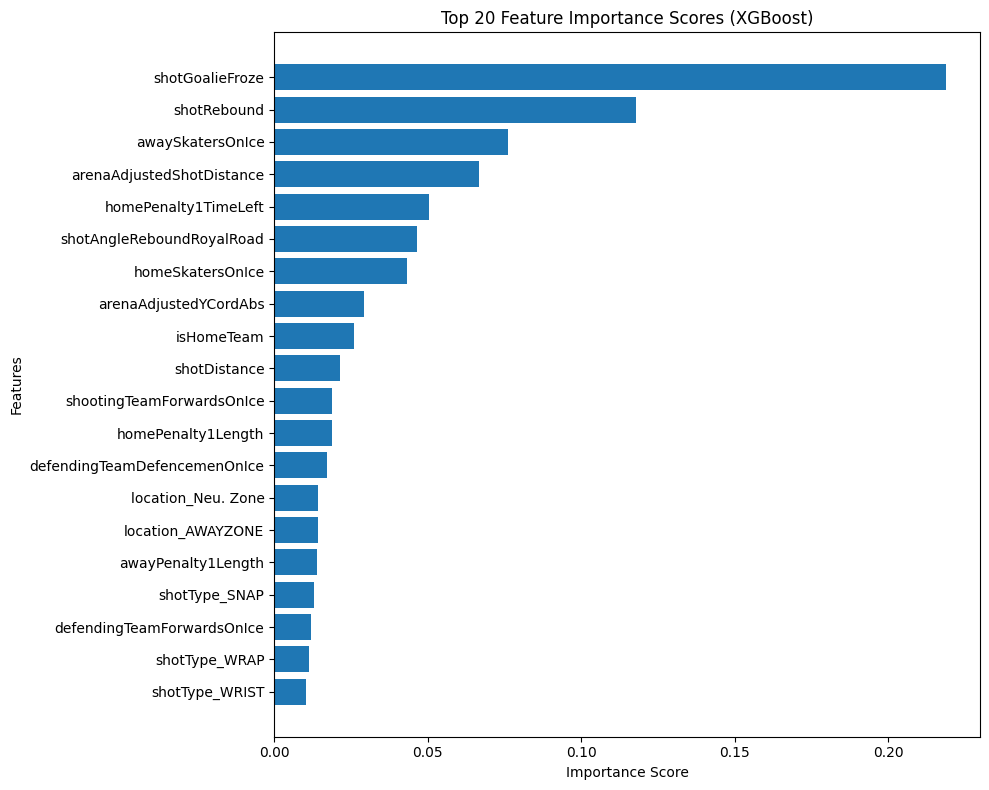


Features for 90% cumulative importance: 29
                      Feature Importance Cumulative_Importance
4             shotGoalieFroze   0.218895              0.218895
15                shotRebound   0.117922              0.336817
27           awaySkatersOnIce   0.076222              0.413038
82  arenaAdjustedShotDistance   0.066637              0.479675
30       homePenalty1TimeLeft    0.05053              0.530205
12  shotAngleReboundRoyalRoad   0.046615              0.576821
26           homeSkatersOnIce   0.043404              0.620225
85      arenaAdjustedYCordAbs   0.029135               0.64936
88                 isHomeTeam   0.025877              0.675237
13               shotDistance   0.021305              0.696542


In [183]:
feature_importance = xgb_model.feature_importances_
feature_names = X_train.columns.tolist()
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 20 Feature Importance Scores (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

importance_df['Cumulative_Importance'] = importance_df['Importance'].cumsum()
selected_features = importance_df[importance_df['Cumulative_Importance'] <= 0.9]
if len(selected_features) < len(importance_df):
    next_feature = importance_df.iloc[len(selected_features)]
    selected_features = pd.concat([selected_features, next_feature.to_frame().T])

print(f"\nFeatures for 90% cumulative importance: {len(selected_features)}")
print(selected_features[['Feature', 'Importance', 'Cumulative_Importance']].head(10))


In [184]:
test_predictions = {}
test_times = {}
test_proba = {}

for model_name, model in models.items():
    start_time = time.time()
    y_pred = model.predict(X_test_scaled)
    test_times[model_name] = (time.time() - start_time) * 1000
    test_predictions[model_name] = y_pred
    
    if hasattr(model, 'predict_proba'):
        test_proba[model_name] = model.predict_proba(X_test_scaled)

results = []
for model_name in models.keys():
    y_pred = test_predictions[model_name]
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    if model_name in test_proba:
        brier = brier_score_loss(y_test, test_proba[model_name][:, 1])
        logloss = log_loss(y_test, test_proba[model_name])
        y_proba = test_proba[model_name][:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
    else:
        brier = None
        logloss = None
        roc_auc = None
    
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'ROC-AUC': roc_auc,
        'Brier Score': brier,
        'Log Loss': logloss,
        'Test Time (ms)': test_times[model_name]
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))


              Model  Accuracy  Precision   Recall       F1  ROC-AUC  Brier Score  Log Loss  Test Time (ms)
Logistic Regression  0.937951   0.926228 0.937951 0.911760 0.806757     0.052785  0.196063       26.235342
            XGBoost  0.942636   0.935310 0.942636 0.923169 0.847709     0.048384  0.177100       69.509506
           LightGBM  0.942822   0.938467 0.942822 0.922452 0.848122     0.048324  0.177163      175.292492


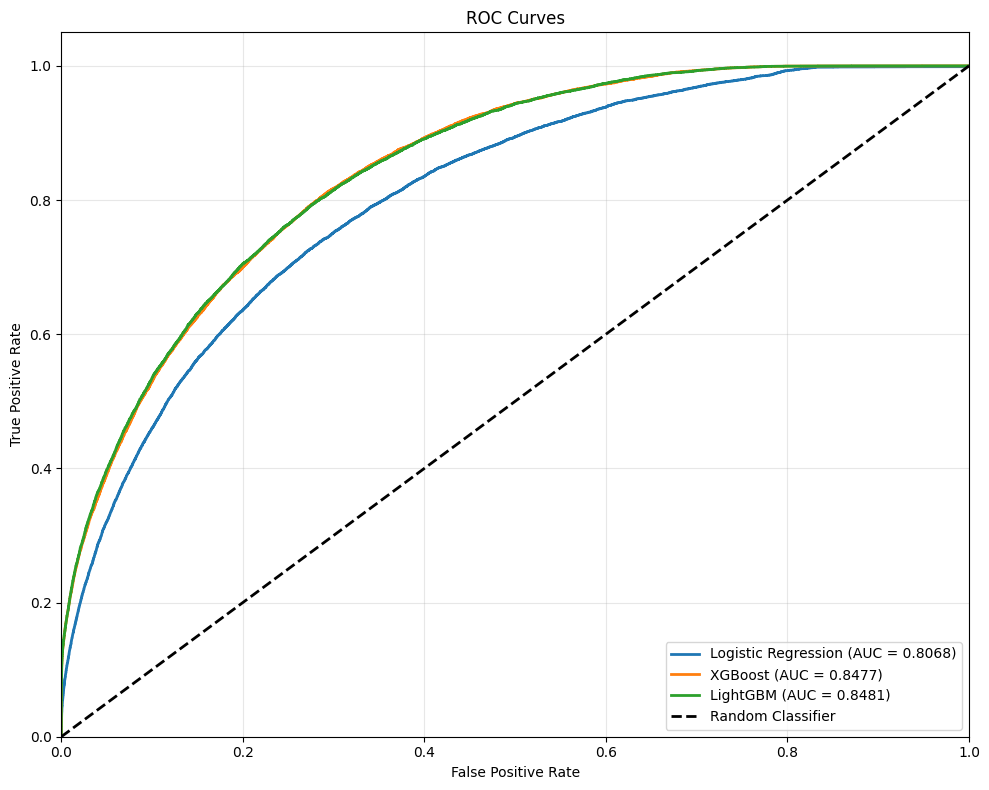

In [185]:
plt.figure(figsize=(10, 8))
for model_name in models.keys():
    if model_name in test_proba:
        y_proba = test_proba[model_name][:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


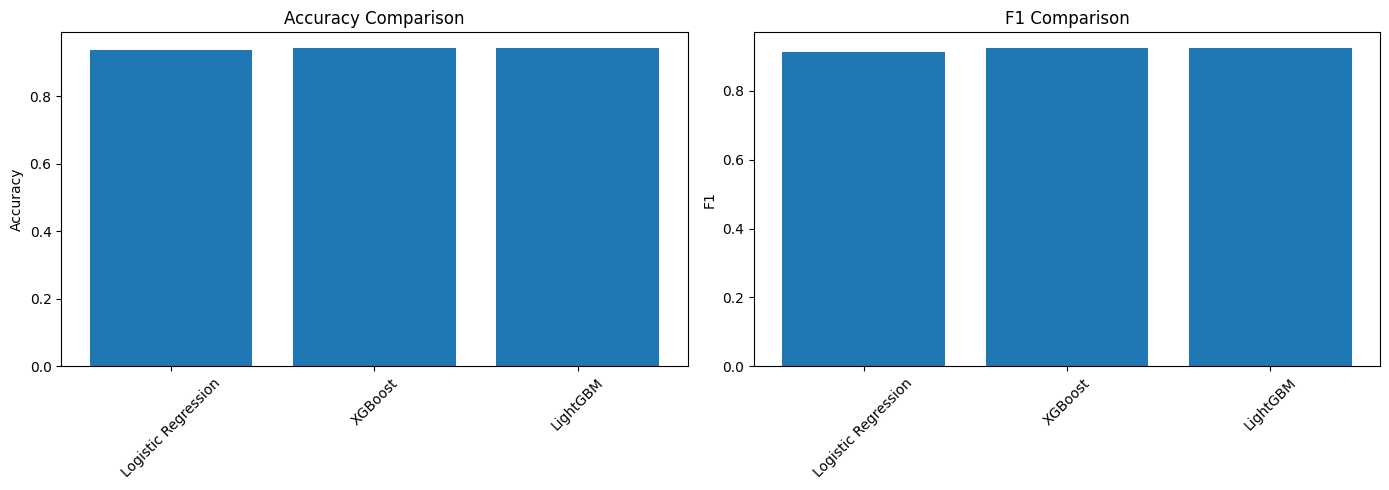


Best model by accuracy: LightGBM


In [186]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

metrics = ['Accuracy', 'F1']
for idx, metric in enumerate(metrics):
    axes[idx].bar(results_df['Model'], results_df[metric])
    axes[idx].set_ylabel(metric)
    axes[idx].set_title(f'{metric} Comparison')
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

best_model_name = results_df.loc[results_df['Accuracy'].idxmax(), 'Model']
print(f"\nBest model by accuracy: {best_model_name}")


In [187]:
best_model = models[best_model_name]

if hasattr(best_model, 'coef_'):
    l2_penalty = np.sum(best_model.coef_**2)
    print(f"L2 penalty (sum of squared coefficients): {l2_penalty:.4f}")

ridge_model = Ridge(alpha=0.5, random_state=42)
ridge_model.fit(X_train_scaled, y_train)
ridge_pred = ridge_model.predict(X_test_scaled)
ridge_pred_binary = (ridge_pred > 0.5).astype(int)
ridge_mse = np.mean((y_test - ridge_pred)**2)
print(f"Ridge Regression MSE: {ridge_mse:.4f}")


Ridge Regression MSE: 0.0556


Original Brier Score: 0.0483
Calibrated Brier Score: 0.0483


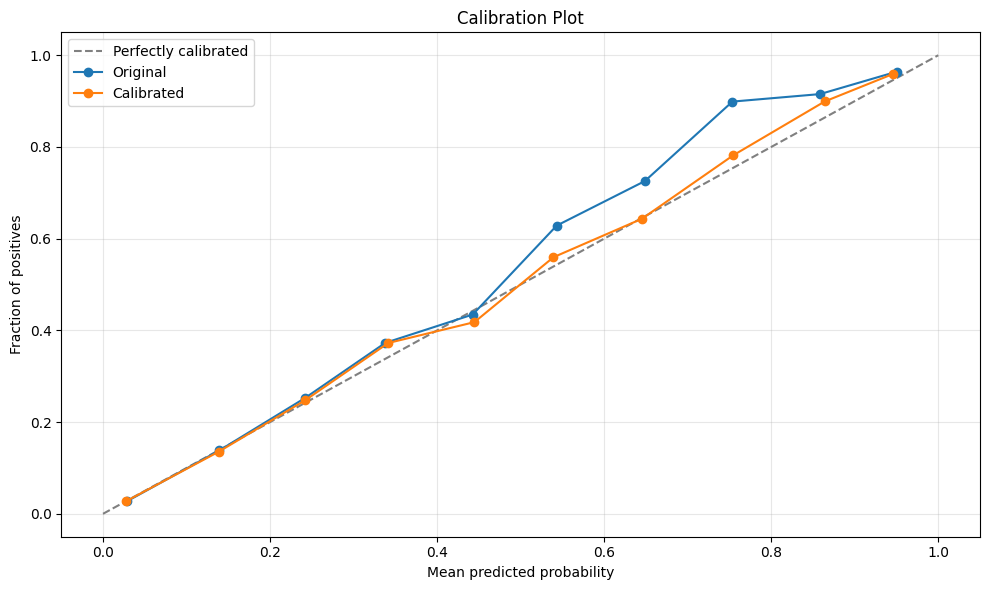

In [188]:
if best_model_name in test_proba:
    calibrated_model = CalibratedClassifierCV(best_model, method='isotonic', cv=3)
    calibrated_model.fit(X_train_scaled, y_train)
    calibrated_proba = calibrated_model.predict_proba(X_test_scaled)
    
    original_proba = test_proba[best_model_name][:, 1]
    calibrated_proba_pos = calibrated_proba[:, 1]
    
    print(f"Original Brier Score: {brier_score_loss(y_test, original_proba):.4f}")
    print(f"Calibrated Brier Score: {brier_score_loss(y_test, calibrated_proba_pos):.4f}")
    
    from sklearn.calibration import calibration_curve
    
    prob_true_orig, prob_pred_orig = calibration_curve(y_test, original_proba, n_bins=10)
    prob_true_cal, prob_pred_cal = calibration_curve(y_test, calibrated_proba_pos, n_bins=10)
    
    plt.figure(figsize=(10, 6))
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated', color='gray')
    plt.plot(prob_pred_orig, prob_true_orig, marker='o', label='Original')
    plt.plot(prob_pred_cal, prob_true_cal, marker='o', label='Calibrated')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title('Calibration Plot')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


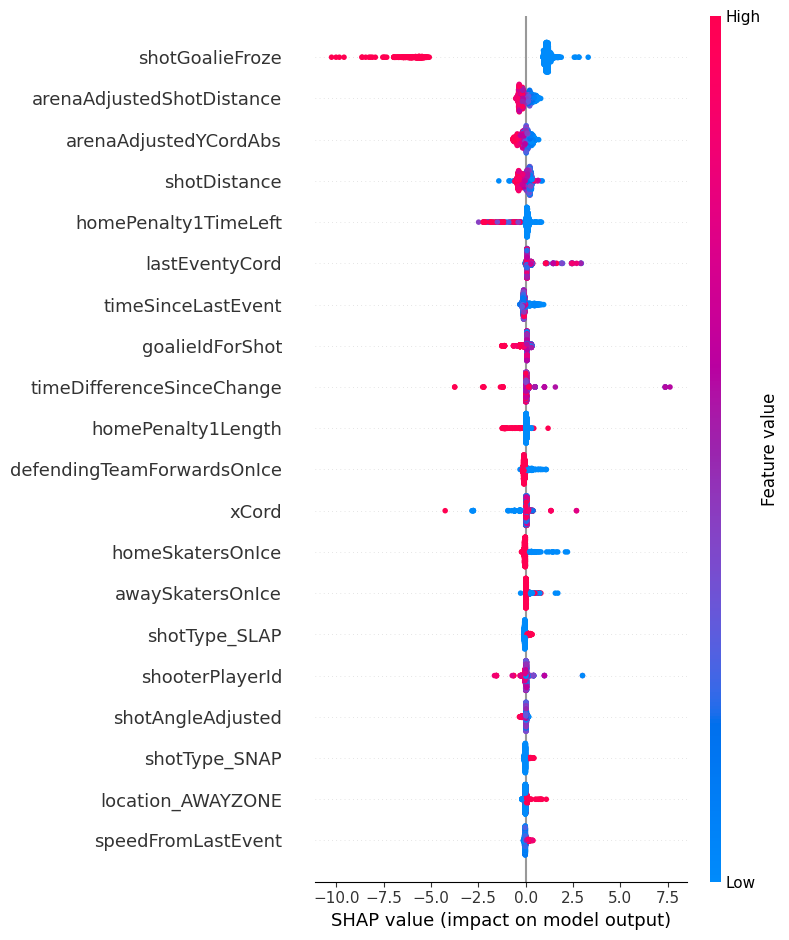


Top 10 features by SHAP importance:
                      Feature  SHAP Importance
4             shotGoalieFroze         2.027325
82  arenaAdjustedShotDistance         0.265225
85      arenaAdjustedYCordAbs         0.215355
13               shotDistance         0.212237
30       homePenalty1TimeLeft         0.199141
20             lastEventyCord         0.193627
2          timeSinceLastEvent         0.146462
37            goalieIdForShot         0.141374
86  timeDifferenceSinceChange         0.119791
31         homePenalty1Length         0.109578


In [189]:
if best_model_name in ['XGBoost', 'LightGBM']:
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test_scaled[:1000])
    
    if isinstance(shap_values, list):
        shap_values = shap_values[1]
    
    shap.summary_plot(shap_values, X_test_scaled[:1000], feature_names=X_train.columns.tolist(), 
                     max_display=20, show=False)
    plt.tight_layout()
    plt.show()
    
    shap_values_mean = np.abs(shap_values).mean(0)
    feature_importance_shap = pd.DataFrame({
        'Feature': X_train.columns.tolist(),
        'SHAP Importance': shap_values_mean
    }).sort_values('SHAP Importance', ascending=False)
    
    print("\nTop 10 features by SHAP importance:")
    print(feature_importance_shap.head(10))
else:
    print("SHAP analysis skipped (best model is not tree-based)")


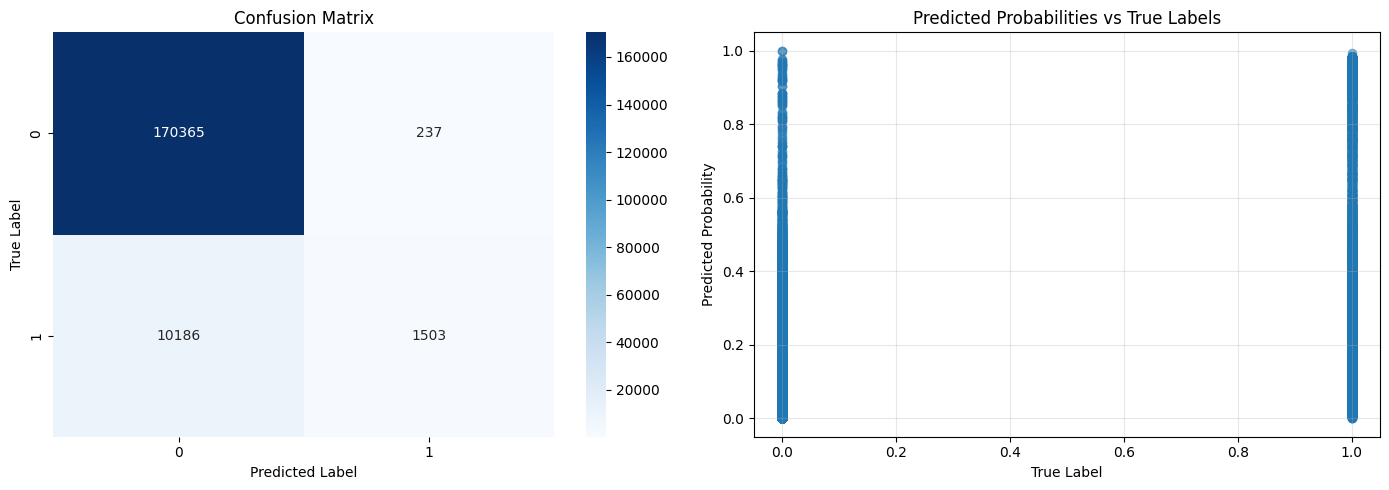


Final Model Performance (LightGBM):
Accuracy: 0.9428
F1-Score: 0.9225
Brier Score: 0.0483
Log Loss: 0.1772


In [190]:
if best_model_name in test_proba:
    y_pred_best = test_predictions[best_model_name]
    y_proba_best = test_proba[best_model_name][:, 1]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    cm = confusion_matrix(y_test, y_pred_best)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')
    
    axes[1].scatter(y_test, y_proba_best, alpha=0.5)
    axes[1].set_xlabel('True Label')
    axes[1].set_ylabel('Predicted Probability')
    axes[1].set_title('Predicted Probabilities vs True Labels')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nFinal Model Performance ({best_model_name}):")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred_best, average='weighted'):.4f}")
    if best_model_name in test_proba:
        print(f"Brier Score: {brier_score_loss(y_test, y_proba_best):.4f}")
        print(f"Log Loss: {log_loss(y_test, test_proba[best_model_name]):.4f}")


In [191]:
print("\nSummary:")
print(f"Best performing model: {best_model_name}")
print(f"Test Accuracy: {results_df.loc[results_df['Model'] == best_model_name, 'Accuracy'].values[0]:.4f}")
print(f"Test F1-Score: {results_df.loc[results_df['Model'] == best_model_name, 'F1'].values[0]:.4f}")
print(f"\nTotal models evaluated: {len(models)}")
print(f"Training time range: {min(training_times.values()):.2f} - {max(training_times.values()):.2f} ms")



Summary:
Best performing model: LightGBM
Test Accuracy: 0.9428
Test F1-Score: 0.9225

Total models evaluated: 3
Training time range: 8106.45 - 12192.37 ms
